In [1]:
# Import our dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Fix a random seed so the data can be reproduced
np.random.seed(24)

# Upload and read the csv files
ais_df = pd.read_csv("ml_data_daily_2018.csv", index_col=0)

In [2]:
# Look at our data
ais_df.head()

,Fishing,TugTow,Recreational,Passenger,Cargo,Tanker,Other,Unavailable
2018/01/01,9,37,145,44,27,13,12,7
2018/01/02,13,45,119,41,27,14,19,10
2018/01/03,13,44,106,40,36,14,20,11
2018/01/04,15,44,103,45,30,10,15,12
2018/01/05,10,45,107,41,26,13,21,10


In [3]:
# Creating a total column for our data
ais_df['Total']= ais_df.sum(numeric_only=True, axis=1)
ais_df.head()

,Fishing,TugTow,Recreational,Passenger,Cargo,Tanker,Other,Unavailable,Total
2018/01/01,9,37,145,44,27,13,12,7,294
2018/01/02,13,45,119,41,27,14,19,10,288
2018/01/03,13,44,106,40,36,14,20,11,284
2018/01/04,15,44,103,45,30,10,15,12,274
2018/01/05,10,45,107,41,26,13,21,10,273


In [4]:
# And then check the type
ais_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 2018/01/01 to 2018/12/31
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Fishing       365 non-null    int64
 1   TugTow        365 non-null    int64
 2   Recreational  365 non-null    int64
 3   Passenger     365 non-null    int64
 4   Cargo         365 non-null    int64
 5   Tanker        365 non-null    int64
 6   Other         365 non-null    int64
 7   Unavailable   365 non-null    int64
 8   Total         365 non-null    int64
dtypes: int64(9)
memory usage: 28.5+ KB


In [5]:
# Create nine DataFrames, each with the Date and one unique column:

# Fishing
ais_fishing_df = ais_df.loc[:, ['Fishing']]

# TugTow
ais_tugtow_df = ais_df.loc[:, ['TugTow']]

# Recreational
ais_recreational_df = ais_df.loc[:, ['Recreational']]

# Passenger
ais_passenger_df = ais_df.loc[:, ['Passenger']]

# Cargo
ais_cargo_df = ais_df.loc[:, ['Cargo']]

# Tanker
ais_tanker_df = ais_df.loc[:, ['Tanker']]

# Other
ais_other_df = ais_df.loc[:, ['Other']]

# Unavailable
ais_unavailable_df = ais_df.loc[:, ['Unavailable']]

# Total
ais_total_df = ais_df.loc[:, ['Total']]

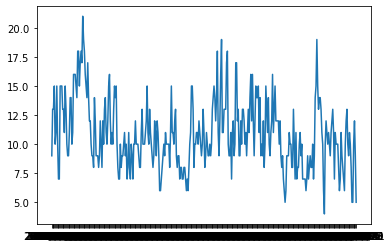

In [6]:
plt.plot(ais_fishing_df)
plt.show()

In [7]:
# From here, the code is heavily inspired by the code found on this site:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [8]:
# Convert the nine DataFrames into an arrays, and change the type to floats for the Neural Network

# Fishing
fishing = ais_fishing_df.values
fishing = fishing.astype('float32')

# TugTow
tugtow = ais_tugtow_df.values
tugtow = tugtow.astype('float32')

# Recreational
recreational = ais_recreational_df.values
recreational = recreational.astype('float32')

# Passenger
passenger = ais_passenger_df.values
passenger = passenger.astype('float32')

# Cargo
cargo = ais_cargo_df.values
cargo = cargo.astype('float32')

# Tanker
tanker = ais_tanker_df.values
tanker = tanker.astype('float32')

# Other
other = ais_other_df.values
other = other.astype('float32')

# Unavailable
unavailable = ais_unavailable_df.values
unavailable = unavailable.astype('float32')

# Total
total = ais_total_df.values
total = total.astype('float32')

In [9]:
# Normalize the data by using a scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fishing
fishing = scaler.fit_transform(fishing)

# Tugtow
tugtow = scaler.fit_transform(tugtow)

# Recreational
recreational = scaler.fit_transform(recreational)

# Passenger
passenger = scaler.fit_transform(passenger)

# Cargo
cargo = scaler.fit_transform(cargo)

# Tanker
tanker = scaler.fit_transform(tanker)

# Other
other = scaler.fit_transform(other)

# Unavailable
unavailable = scaler.fit_transform(unavailable)

# Total
total = scaler.fit_transform(total)

In [10]:
# Create a function that allows the testing/training data to be split into X and Y
# by converting the values of the dataset into a matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
# Define the number of days we are going to look into the past to compare data as look_back. 
look_back = 1

### Fishing

In [12]:
# Split our data into training and testing using slicing, and check the length

train_size_fish = int(len(fishing) * 0.67)
test_size_fish = len(fishing) - train_size_fish
train_fish, test_fish = fishing[0:train_size_fish,:], fishing[train_size_fish:len(total),:]
print(len(train_fish), len(test_fish))

244 121


In [13]:
# Reshape the values into X=t and Y=t+1
trainX_fish, trainY_fish = create_dataset(train_fish, look_back)
testX_fish, testY_fish = create_dataset(test_fish, look_back)

In [14]:
# Reshape the data to incorperate into the LSTM 
trainX_fish = np.reshape(trainX_fish, (trainX_fish.shape[0], 1, trainX_fish.shape[1]))
testX_fish = np.reshape(testX_fish, (testX_fish.shape[0], 1, testX_fish.shape[1]))

In [15]:
# create and fit the LSTM network
model_fish = Sequential()
model_fish.add(LSTM(4, input_shape=(1, look_back)))
model_fish.add(Dense(1))

In [16]:
# Check the summary of the model
model_fish.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile the model
model_fish.compile(loss='mean_squared_error', optimizer='adam')

In [18]:
# Train the model
fit_model_fish = model_fish.fit(trainX_fish, trainY_fish, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
242/242 - 1s - loss: 0.1026 - 1s/epoch - 5ms/step
Epoch 2/100
242/242 - 0s - loss: 0.0262 - 242ms/epoch - 1ms/step
Epoch 3/100
242/242 - 0s - loss: 0.0230 - 235ms/epoch - 972us/step
Epoch 4/100
242/242 - 0s - loss: 0.0222 - 224ms/epoch - 927us/step
Epoch 5/100
242/242 - 0s - loss: 0.0214 - 231ms/epoch - 955us/step
Epoch 6/100
242/242 - 0s - loss: 0.0206 - 228ms/epoch - 944us/step
Epoch 7/100
242/242 - 0s - loss: 0.0201 - 227ms/epoch - 938us/step
Epoch 8/100
242/242 - 0s - loss: 0.0195 - 230ms/epoch - 951us/step
Epoch 9/100
242/242 - 0s - loss: 0.0190 - 233ms/epoch - 962us/step
Epoch 10/100
242/242 - 0s - loss: 0.0187 - 229ms/epoch - 948us/step
Epoch 11/100
242/242 - 0s - loss: 0.0183 - 234ms/epoch - 968us/step
Epoch 12/100
242/242 - 0s - loss: 0.0181 - 241ms/epoch - 998us/step
Epoch 13/100
242/242 - 0s - loss: 0.0180 - 239ms/epoch - 989us/step
Epoch 14/100
242/242 - 0s - loss: 0.0176 - 241ms/epoch - 997us/step
Epoch 15/100
242/242 - 0s - loss: 0.0175 - 236ms/epoch - 975us/s

In [19]:
# Make predictions
trainPredict_fish = model_fish.predict(trainX_fish)
testPredict_fish = model_fish.predict(testX_fish)

4/4 [==============================] - 0s 2ms/step


In [20]:
# Invert predictions
trainPredict_fish = scaler.inverse_transform(trainPredict_fish)
trainY_fish = scaler.inverse_transform([trainY_fish])
testPredict_fish = scaler.inverse_transform(testPredict_fish)
testY_fish = scaler.inverse_transform([testY_fish])

In [21]:
# Calculate root mean squared error
trainScore_fish = math.sqrt(mean_squared_error(trainY_fish[0], trainPredict_fish[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_fish))
testScore_fish = math.sqrt(mean_squared_error(testY_fish[0], testPredict_fish[:,0]))
print('Test Score: %.2f RMSE' % (testScore_fish))

Train Score: 32.70 RMSE
Test Score: 32.89 RMSE


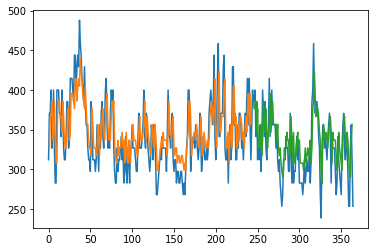

In [22]:
# shift train predictions for plotting
trainPredictPlot_fish = np.empty_like(fishing)
trainPredictPlot_fish[:, :] = np.nan
trainPredictPlot_fish[look_back:len(trainPredict_fish)+look_back, :] = trainPredict_fish
# shift test predictions for plotting
testPredictPlot_fish = np.empty_like(fishing)
testPredictPlot_fish[:, :] = np.nan
testPredictPlot_fish[len(trainPredict_fish)+(look_back*2)+1:len(fishing)-1, :] = testPredict_fish
# plot baseline and predictions
plt.plot(scaler.inverse_transform(fishing))
plt.plot(trainPredictPlot_fish)
plt.plot(testPredictPlot_fish)
plt.show()

### TugTow

In [24]:
# Split our data into training and testing using slicing, and check the length

train_size_tugtow = int(len(tugtow) * 0.67)
test_size_tugtow = len(tugtow) - train_size_tugtow
train_tugtow, test_tugtow = tugtow[0:train_size_tugtow,:], tugtow[train_size_tugtow:len(total),:]
print(len(train_tugtow), len(test_tugtow))

244 121


In [25]:
# Reshape the values into X=t and Y=t+1
trainX_tugtow, trainY_tugtow = create_dataset(train_tugtow, look_back)
testX_tugtow, testY_tugtow = create_dataset(test_tugtow, look_back)

In [26]:
# Reshape the values into X=t and Y=t+1
trainX_tugtow, trainY_tugtow = create_dataset(train_tugtow, look_back)
testX_tugtow, testY_tugtow = create_dataset(test_tugtow, look_back)

In [27]:
# Reshape the data to incorperate into the LSTM 
trainX_tugtow = np.reshape(trainX_tugtow, (trainX_tugtow.shape[0], 1, trainX_tugtow.shape[1]))
testX_tugtow = np.reshape(testX_tugtow, (testX_tugtow.shape[0], 1, testX_tugtow.shape[1]))

In [28]:
# create and fit the LSTM network
model_tugtow = Sequential()
model_tugtow.add(LSTM(4, input_shape=(1, look_back)))
model_tugtow.add(Dense(1))

In [29]:
# Check the summary of the model
model_tugtow.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 4)                 96        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Compile the model
model_tugtow.compile(loss='mean_squared_error', optimizer='adam')

In [31]:
# Train the model
fit_model_tugtow = model_tugtow.fit(trainX_tugtow, trainY_tugtow, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
242/242 - 1s - loss: 0.0520 - 1s/epoch - 5ms/step
Epoch 2/100
242/242 - 0s - loss: 0.0153 - 222ms/epoch - 919us/step
Epoch 3/100
242/242 - 0s - loss: 0.0152 - 224ms/epoch - 925us/step
Epoch 4/100
242/242 - 0s - loss: 0.0151 - 230ms/epoch - 951us/step
Epoch 5/100
242/242 - 0s - loss: 0.0151 - 223ms/epoch - 920us/step
Epoch 6/100
242/242 - 0s - loss: 0.0149 - 226ms/epoch - 935us/step
Epoch 7/100
242/242 - 0s - loss: 0.0150 - 229ms/epoch - 948us/step
Epoch 8/100
242/242 - 0s - loss: 0.0149 - 236ms/epoch - 974us/step
Epoch 9/100
242/242 - 0s - loss: 0.0148 - 227ms/epoch - 939us/step
Epoch 10/100
242/242 - 0s - loss: 0.0148 - 230ms/epoch - 950us/step
Epoch 11/100
242/242 - 0s - loss: 0.0147 - 230ms/epoch - 952us/step
Epoch 12/100
242/242 - 0s - loss: 0.0147 - 251ms/epoch - 1ms/step
Epoch 13/100
242/242 - 0s - loss: 0.0148 - 232ms/epoch - 960us/step
Epoch 14/100
242/242 - 0s - loss: 0.0147 - 244ms/epoch - 1ms/step
Epoch 15/100
242/242 - 0s - loss: 0.0148 - 239ms/epoch - 986us/ste

In [32]:
# Make predictions
trainPredict_tugtow = model_tugtow.predict(trainX_tugtow)
testPredict_tugtow = model_tugtow.predict(testX_tugtow)

4/4 [==============================] - 0s 1ms/step


In [33]:
# Invert predictions
trainPredict_tugtow = scaler.inverse_transform(trainPredict_tugtow)
trainY_tugtow = scaler.inverse_transform([trainY_tugtow])
testPredict_tugtow = scaler.inverse_transform(testPredict_tugtow)
testY_tugtow = scaler.inverse_transform([testY_tugtow])

In [34]:
# Calculate root mean squared error
trainScore_tugtow = math.sqrt(mean_squared_error(trainY_tugtow[0], trainPredict_tugtow[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_tugtow))
testScore_tugtow = math.sqrt(mean_squared_error(testY_tugtow[0], testPredict_tugtow[:,0]))
print('Test Score: %.2f RMSE' % (testScore_tugtow))

Train Score: 30.13 RMSE
Test Score: 39.14 RMSE


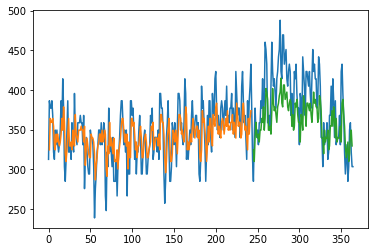

In [35]:
# shift train predictions for plotting
trainPredictPlot_tugtow = np.empty_like(tugtow)
trainPredictPlot_tugtow[:, :] = np.nan
trainPredictPlot_tugtow[look_back:len(trainPredict_tugtow)+look_back, :] = trainPredict_tugtow
# shift test predictions for plotting
testPredictPlot_tugtow = np.empty_like(tugtow)
testPredictPlot_tugtow[:, :] = np.nan
testPredictPlot_tugtow[len(trainPredict_tugtow)+(look_back*2)+1:len(tugtow)-1, :] = testPredict_tugtow
# plot baseline and predictions
plt.plot(scaler.inverse_transform(tugtow))
plt.plot(trainPredictPlot_tugtow)
plt.plot(testPredictPlot_tugtow)
plt.show()